In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [19]:
IMAGE_SIZE = 64        # Image height/width
CHANNELS = 3           # Using color images
BATCH_SIZE = 128
Z_DIM = 128            # Dimension of noise (latent space)
LEARNING_RATE = 0.0002
BETA1 = 0.5
BETA2 = 0.999
EPOCHS = 10
CRITIC_STEPS = 5       # Number of critic iterations per generator iteration
GP_WEIGHT = 10.0       # Gradient penalty lambda

DEVICE = "cpu"

In [3]:
!kaggle datasets download jessicali9530/celeba-dataset
!unzip -q celeba-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
100% 1.33G/1.33G [00:06<00:00, 241MB/s]
100% 1.33G/1.33G [00:06<00:00, 210MB/s]


## 1. Prepare the Data (CelebA)


In [8]:
# This assumes you have a folder "celeba" with images inside subfolders or a single folder.
# If your structure differs, adapt accordingly.

DATA_PATH = "img_align_celeba/img_align_celeba"

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

dataset = torchvision.datasets.ImageFolder(
    root=os.path.dirname(DATA_PATH),  # Folder containing subfolder "img_align_celeba"
    transform=transform
)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [10]:
next(iter(dataloader))[0].shape

torch.Size([128, 3, 64, 64])

## 3. Defining the Critic (Similar to a Discriminator)

In [9]:
class Critic(nn.Module):
    """
    The Critic outputs a SINGLE scalar score for an image.
    No Sigmoid at the end—this is WGAN's difference from typical GANs.
    """
    def __init__(self, channels=3, features_d=64):
        super(Critic, self).__init__()
        # We'll define a series of Conv2d layers with LeakyReLU
        # to downsample from 64x64 to 4x4 (or 1x1 eventually).
        self.model = nn.Sequential(
            # Input: (channels, 64, 64)
            nn.Conv2d(channels, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # (features_d, 32, 32)
            nn.Conv2d(features_d, features_d*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features_d*2),
            nn.LeakyReLU(0.2, inplace=True),

            # (features_d*2, 16, 16)
            nn.Conv2d(features_d*2, features_d*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features_d*4),
            nn.LeakyReLU(0.2, inplace=True),

            # (features_d*4, 8, 8)
            nn.Conv2d(features_d*4, features_d*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features_d*8),
            nn.LeakyReLU(0.2, inplace=True),

            # (features_d*8, 4, 4)
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=1, padding=0),
            # Output shape: (1, 1, 1)

            nn.Flatten(start_dim=1)  # shape: (batch_size, 1)
        )

    def forward(self, x):
        return self.model(x)

## 4. Defining the Generator

In [10]:
class Generator(nn.Module):
    """
    The Generator upsamples from a random noise vector z in R^{Z_DIM}
    to generate a (3, 64, 64) image.
    """
    def __init__(self, z_dim=Z_DIM, channels=CHANNELS, features_g=64):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # Input: (z_dim, 1, 1)
            nn.ConvTranspose2d(Z_DIM, features_g*8, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(features_g*8),
            nn.LeakyReLU(0.2, inplace=True),

            # (features_g*8, 4, 4)
            nn.ConvTranspose2d(features_g*8, features_g*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features_g*4),
            nn.LeakyReLU(0.2, inplace=True),

            # (features_g*4, 8, 8)
            nn.ConvTranspose2d(features_g*4, features_g*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features_g*2),
            nn.LeakyReLU(0.2, inplace=True),

            # (features_g*2, 16, 16)
            nn.ConvTranspose2d(features_g*2, features_g, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features_g),
            nn.LeakyReLU(0.2, inplace=True),

            # (features_g, 32, 32)
            nn.ConvTranspose2d(features_g, CHANNELS, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
            # Output shape: (channels, 64, 64)
        )

    def forward(self, x):
        return self.model(x)

In [35]:
critic = Critic(channels=CHANNELS, features_d=IMAGE_SIZE).to(DEVICE)
generator = Generator(z_dim=Z_DIM, channels=CHANNELS, features_g=IMAGE_SIZE).to(DEVICE)

# WGAN-GP often uses Adam with betas=(0.5, 0.999) or a small tweak
critic_optimizer = optim.Adam(critic.parameters(), lr=2e-4, betas=(BETA1, BETA2))
generator_optimizer = optim.Adam(generator.parameters(), lr=2e-4, betas=(BETA1, BETA2))

## 6. Gradient Penalty (GP)

In [34]:
def gradient_penalty(critic, real, fake, device="cpu"):
    """
    Compute the gradient penalty for WGAN-GP.
    1. Randomly interpolate between real and fake.
    2. Calculate gradient of Critic’s output w.r.t. this interpolated data.
    3. Penalize deviations of gradient norm from 1.
    """
    batch_size, c, h, w = real.shape
    alpha = torch.rand((batch_size, 1, 1, 1), device=device).repeat(1, c, h, w)

    # Create interpolated images
    interpolated = real * alpha + fake * (1 - alpha)
    interpolated.requires_grad_(True)

    # Critic score on interpolated images
    mixed_scores = critic(interpolated)

    # Take gradient of scores w.r.t. interpolated images
    gradient = torch.autograd.grad(
        inputs=interpolated,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True
    )[0]  # tuple of length 1

    # Flatten gradients: shape => (batch_size, all pixels)
    gradient = gradient.view(gradient.size(0), -1)
    # L2 norm
    gradient_norm = gradient.norm(2, dim=1)
    # GP = E[(||gradient||2 - 1)^2]
    gp = torch.mean((gradient_norm - 1) ** 2)
    return gp

## 7. Compile and Train

In [ ]:
from tqdm import tqdm

print("Starting Training...")
g_losses = []
c_losses = []

for epoch in range(EPOCHS):
    # Create a progress bar for this epoch
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch_idx, (real_images, _) in progress_bar:
        real_images = real_images.to(DEVICE)
        cur_batch_size = real_images.shape[0]

        # -----------------------------
        # (a) Train Critic multiple times
        # -----------------------------
        for _ in range(CRITIC_STEPS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1, device=DEVICE)
            fake_images = generator(noise)

            critic_optimizer.zero_grad()

            # Critic scores
            critic_real = critic(real_images).view(-1)
            critic_fake = critic(fake_images).view(-1)

            # Wasserstein distance
            wass_distance = torch.mean(critic_fake) - torch.mean(critic_real)

            # Gradient penalty
            gp = gradient_penalty(critic, real_images, fake_images, device=DEVICE)

            # Critic total loss
            critic_loss = wass_distance + GP_WEIGHT * gp
            critic_loss.backward(retain_graph=True)
            critic_optimizer.step()

        # -----------------------------
        # (b) Train Generator
        # -----------------------------
        generator_optimizer.zero_grad()
        critic_fake_for_g = critic(fake_images).view(-1)  # Reuse fake_images from last loop
        gen_loss = -torch.mean(critic_fake_for_g)
        gen_loss.backward()
        generator_optimizer.step()

        # Save losses
        c_losses.append(critic_loss.item())
        g_losses.append(gen_loss.item())

        # Update the tqdm progress bar with the latest losses
        progress_bar.set_postfix({
            "Critic Loss": f"{critic_loss.item():.4f}",
            "GP": f"{gp.item():.4f}",
            "WassDist": f"{wass_distance.item():.4f}",
            "Gen Loss": f"{gen_loss.item():.4f}",
        })


## 8. Plot losses

For the rest of the notebook, we will be using the allready trained models from the professor

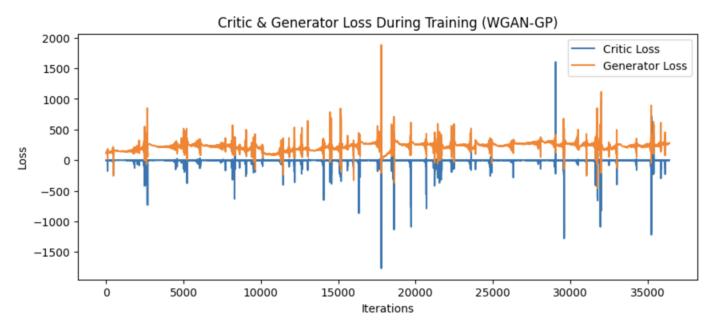

In [33]:
from PIL import Image

losses = Image.open("losses.png")
plt.figure(figsize=(10,4))
plt.imshow(losses)
plt.axis("off")
plt.show()

In [22]:
critic = Critic(channels=CHANNELS, features_d=IMAGE_SIZE).to(DEVICE)
# Load the state dictionary, but map the location to 'cpu'
critic.load_state_dict(torch.load("2_gan_gp_discriminator.pth", map_location=torch.device('cpu'), weights_only=True))

generator = Generator(z_dim=Z_DIM, channels=CHANNELS, features_g=IMAGE_SIZE).to(DEVICE)
# Load the state dictionary, but map the location to 'cpu'
generator.load_state_dict(torch.load("2_gan_gp_generator.pth", map_location=torch.device('cpu'), weights_only=True))

<All keys matched successfully>

## 9. Generate Images & Evaluate

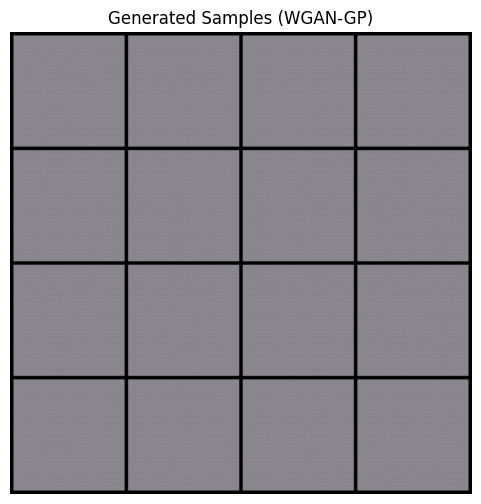

In [36]:
def show_generated_samples(generator, num_samples=16, z_dim=Z_DIM):
    """
    Generate 'num_samples' images from the generator and display them in a grid.
    """
    generator.eval()
    noise = torch.randn(num_samples, z_dim, 1, 1).to(DEVICE)
    with torch.no_grad():
        fake = generator(noise)
    fake = fake.cpu() * 0.5 + 0.5  # Denormalize from [-1,1] to [0,1]

    grid_img = torchvision.utils.make_grid(fake, nrow=4)
    plt.figure(figsize=(6,6))
    plt.imshow(grid_img.permute(1, 2, 0).numpy())
    plt.axis("off")
    plt.title("Generated Samples (WGAN-GP)")
    plt.show()
    generator.train()

show_generated_samples(generator, num_samples=16)